# CNN  Classification  without Data Augmentation

# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.

# Load nessecerry modules

In [1]:
!pip install tqdm

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import os, tarfile, random, pickle
from unittest.mock import MagicMock
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [3]:
def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels


def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        #indices = np.arange(features.shape[0])
        #np.random.shuffle(indices)
        #features = features[indices]
        #labels = np.array(labels)[indices].tolist()
        
        validation_count = int(len(features) * 0.1)
        
        # Prprocess and save a batch of training data
        
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')
        
        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the test data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all test data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_test.p')


def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [4]:
def _print_success_message():
    print('Tests Passed')


def test_folder_path(cifar10_dataset_folder_path):
    assert cifar10_dataset_folder_path is not None,\
        'Cifar-10 data folder not set.'
    assert cifar10_dataset_folder_path[-1] != '/',\
        'The "/" shouldn\'t be added to the end of the path.'
    assert os.path.exists(cifar10_dataset_folder_path),\
        'Path not found.'
    assert os.path.isdir(cifar10_dataset_folder_path),\
        '{} is not a folder.'.format(os.path.basename(cifar10_dataset_folder_path))

    train_files = [cifar10_dataset_folder_path + '/data_batch_' + str(batch_id) for batch_id in range(1, 6)]
    other_files = [cifar10_dataset_folder_path + '/batches.meta', cifar10_dataset_folder_path + '/test_batch']
    missing_files = [path for path in train_files + other_files if not os.path.exists(path)]

    assert not missing_files,\
        'Missing files in directory: {}'.format(missing_files)

    print('All files found!')


def test_normalize(normalize):
    test_shape = (np.random.choice(range(1000)), 32, 32, 3)
    test_numbers = np.random.choice(range(256), test_shape)
    normalize_out = normalize(test_numbers)

    assert type(normalize_out).__module__ == np.__name__,\
        'Not Numpy Object'

    assert normalize_out.shape == test_shape,\
        'Incorrect Shape. {} shape found'.format(normalize_out.shape)

    assert normalize_out.max() <= 1 and normalize_out.min() >= 0,\
        'Incorect Range. {} to {} found'.format(normalize_out.min(), normalize_out.max())

    _print_success_message()


def test_one_hot_encode(one_hot_encode):
    test_shape = np.random.choice(range(1000))
    test_numbers = np.random.choice(range(10), test_shape)
    one_hot_out = one_hot_encode(test_numbers)

    assert type(one_hot_out).__module__ == np.__name__,\
        'Not Numpy Object'

    assert one_hot_out.shape == (test_shape, 10),\
        'Incorrect Shape. {} shape found'.format(one_hot_out.shape)

    n_encode_tests = 5
    test_pairs = list(zip(test_numbers, one_hot_out))
    test_indices = np.random.choice(len(test_numbers), n_encode_tests)
    labels = [test_pairs[test_i][0] for test_i in test_indices]
    enc_labels = np.array([test_pairs[test_i][1] for test_i in test_indices])
    new_enc_labels = one_hot_encode(labels)

    assert np.array_equal(enc_labels, new_enc_labels),\
        'Encodings returned different results for the same numbers.\n' \
        'For the first call it returned:\n' \
        '{}\n' \
        'For the second call it returned\n' \
        '{}\n' \
        'Make sure you save the map of labels to encodings outside of the function.'.format(enc_labels, new_enc_labels)

    _print_success_message()


def test_nn_image_inputs(neural_net_image_input):
    image_shape = (32, 32, 3)
    nn_inputs_out_x = neural_net_image_input(image_shape)

    assert nn_inputs_out_x.get_shape().as_list() == [None, image_shape[0], image_shape[1], image_shape[2]],\
        'Incorrect Image Shape.  Found {} shape'.format(nn_inputs_out_x.get_shape().as_list())

    assert nn_inputs_out_x.op.type == 'Placeholder',\
        'Incorrect Image Type.  Found {} type'.format(nn_inputs_out_x.op.type)

    assert nn_inputs_out_x.name == 'x:0', \
        'Incorrect Name.  Found {}'.format(nn_inputs_out_x.name)

    print('Image Input Tests Passed.')


def test_nn_label_inputs(neural_net_label_input):
    n_classes = 10
    nn_inputs_out_y = neural_net_label_input(n_classes)

    assert nn_inputs_out_y.get_shape().as_list() == [None, n_classes],\
        'Incorrect Label Shape.  Found {} shape'.format(nn_inputs_out_y.get_shape().as_list())

    assert nn_inputs_out_y.op.type == 'Placeholder',\
        'Incorrect Label Type.  Found {} type'.format(nn_inputs_out_y.op.type)

    assert nn_inputs_out_y.name == 'y:0', \
        'Incorrect Name.  Found {}'.format(nn_inputs_out_y.name)

    print('Label Input Tests Passed.')


def test_nn_keep_prob_inputs(neural_net_keep_prob_input):
    nn_inputs_out_k = neural_net_keep_prob_input()

    assert nn_inputs_out_k.get_shape().ndims is None,\
        'Too many dimensions found for keep prob.  Found {} dimensions.  It should be a scalar (0-Dimension Tensor).'.format(nn_inputs_out_k.get_shape().ndims)

    assert nn_inputs_out_k.op.type == 'Placeholder',\
        'Incorrect keep prob Type.  Found {} type'.format(nn_inputs_out_k.op.type)

    assert nn_inputs_out_k.name == 'keep_prob:0', \
        'Incorrect Name.  Found {}'.format(nn_inputs_out_k.name)

    print('Keep Prob Tests Passed.')


def test_con_pool(conv2d_maxpool):
    test_x = tf.placeholder(tf.float32, [None, 32, 32, 5])
    test_num_outputs = 10
    test_con_k = (2, 2)
    test_con_s = (4, 4)
    test_pool_k = (2, 2)
    test_pool_s = (2, 2)

    conv2d_maxpool_out = conv2d_maxpool(test_x, test_num_outputs, test_con_k, test_con_s, test_pool_k, test_pool_s)

    assert conv2d_maxpool_out.get_shape().as_list() == [None, 4, 4, 10],\
        'Incorrect Shape.  Found {} shape'.format(conv2d_maxpool_out.get_shape().as_list())

    _print_success_message()


def test_flatten(flatten):
    test_x = tf.placeholder(tf.float32, [None, 10, 30, 6])
    flat_out = flatten(test_x)

    assert flat_out.get_shape().as_list() == [None, 10*30*6],\
        'Incorrect Shape.  Found {} shape'.format(flat_out.get_shape().as_list())

    _print_success_message()


def test_fully_conn(fully_conn):
    test_x = tf.placeholder(tf.float32, [None, 128])
    test_num_outputs = 40

    fc_out = fully_conn(test_x, test_num_outputs)

    assert fc_out.get_shape().as_list() == [None, 40],\
        'Incorrect Shape.  Found {} shape'.format(fc_out.get_shape().as_list())

    _print_success_message()


def test_output(output):
    test_x = tf.placeholder(tf.float32, [None, 128])
    test_num_outputs = 40

    output_out = output(test_x, test_num_outputs)

    assert output_out.get_shape().as_list() == [None, 40],\
        'Incorrect Shape.  Found {} shape'.format(output_out.get_shape().as_list())

    _print_success_message()


def test_conv_net(conv_net):
    test_x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    test_k = tf.placeholder(tf.float32)

    logits_out = conv_net(test_x, test_k)

    assert logits_out.get_shape().as_list() == [None, 10],\
        'Incorrect Model Output.  Found {}'.format(logits_out.get_shape().as_list())

    print('Neural Network Built!')


def test_train_nn(train_neural_network):
    mock_session = tf.Session()
    test_x = np.random.rand(128, 32, 32, 3)
    test_y = np.random.rand(128, 10)
    test_k = np.random.rand(1)
    test_optimizer = tf.train.AdamOptimizer()

    mock_session.run = MagicMock()
    train_neural_network(mock_session, test_optimizer, test_k, test_x, test_y)

    assert mock_session.run.called, 'Session not used'

    _print_success_message()

## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [5]:
cifar10_dataset_folder_path = 'cifar-10-batches-py' 

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

tar_gz_path = 'cifar-10-python.tar.gz'

if not isdir(cifar10_dataset_folder_path):
    if not isfile(tar_gz_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
            urlretrieve(
                'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                tar_gz_path,
                pbar.hook)
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()

test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 6:
Image - Min Value: 7 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


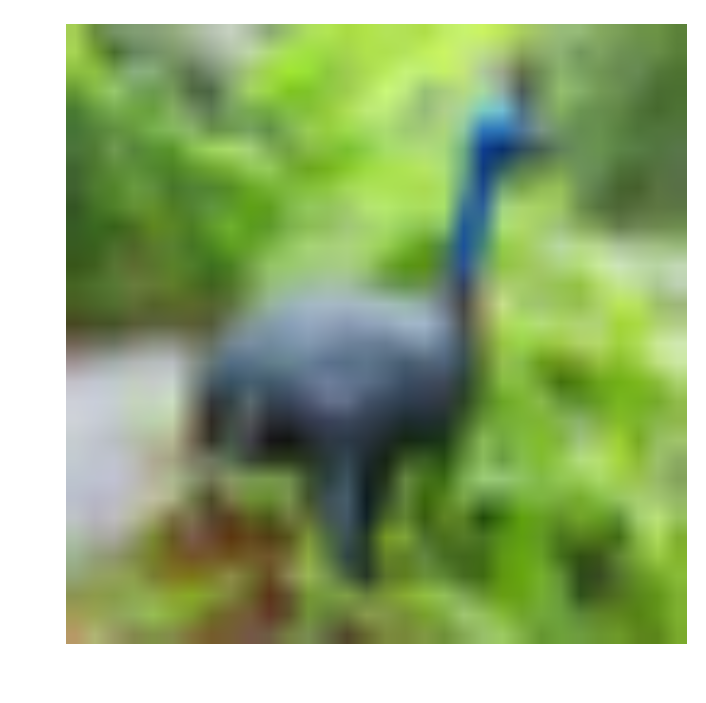

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Explore the dataset
batch_id = 1
sample_id = 6
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [7]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    norm = (x-x.min())/(x.max()-x.min())
    return norm

### One-hot encode
Just like the previous code cell, you'll be implementing a function for preprocessing.  This time, you'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  Make sure to save the map of encodings outside the function.

Hint: Don't reinvent the wheel.

In [8]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    encoding = np.eye(10)[x]
    return encoding

### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [9]:
# Preprocess Training, Validation, and Testing Data
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [10]:
# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

>**Note:** If you're finding it hard to dedicate enough time for this course each week, we've provided a small shortcut to this part of the project. In the next couple of problems, you'll have the option to use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages to build each layer, except the layers you build in the "Convolutional and Max Pooling Layer" section.  TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

>However, if you would like to get the most out of this course, try to solve all the problems _without_ using anything from the TF Layers packages. You **can** still use classes from other packages that happen to have the same name as ones you find in TF Layers! For example, instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), you would want to use the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

Let's begin!

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [11]:
def neural_net_input(image_shape, n_classes):
    # Grouping nodes into a single name scope in the computation graph.
    with tf.name_scope('inputs'):
        x = tf.placeholder(tf.float32, [None] + list(image_shape), name='x')
        y = tf.placeholder(tf.float32, [None ,n_classes], name='y')
        keep_prob_1 = tf.placeholder(tf.float32, None, name="keep_prob_1")
        keep_prob_2 = tf.placeholder(tf.float32, None, name="keep_prob_2")
        learning_rate = tf.placeholder(tf.float32, None, "lr")
        is_training=tf.placeholder(tf.bool, None, name='is_training')
    return x, y, keep_prob_1, keep_prob_2, learning_rate, is_training
'''
def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    # usage : tf.placeholder(dtype, shape=None, name=None)
    return tf.placeholder(tf.float32, [None] + list(image_shape), name='x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, [None ,n_classes], name='y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, None, name="keep_prob")
'''

'\ndef neural_net_image_input(image_shape):\n    """\n    Return a Tensor for a batch of image input\n    : image_shape: Shape of the images\n    : return: Tensor for image input.\n    """\n    # TODO: Implement Function\n    # usage : tf.placeholder(dtype, shape=None, name=None)\n    return tf.placeholder(tf.float32, [None] + list(image_shape), name=\'x\')\n\n\ndef neural_net_label_input(n_classes):\n    """\n    Return a Tensor for a batch of label input\n    : n_classes: Number of classes\n    : return: Tensor for label input.\n    """\n    # TODO: Implement Function\n    return tf.placeholder(tf.float32, [None ,n_classes], name=\'y\')\n\n\ndef neural_net_keep_prob_input():\n    """\n    Return a Tensor for keep probability\n    : return: Tensor for keep probability.\n    """\n    # TODO: Implement Function\n    return tf.placeholder(tf.float32, None, name="keep_prob")\n'

### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.

**Note:** You **can't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for **this** layer, but you can still use TensorFlow's [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) package. You may still use the shortcut option for all the **other** layers.

In [12]:
def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides, is_training, kernel_regularizer=None):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    : return: A tensor that represents convolution of x_tensor
    """
    # TODO: Implement Function
    X_shape = x_tensor.get_shape().as_list()
    C_kshape = list(conv_ksize + (X_shape[-1],) + (conv_num_outputs,))
    
    # The shape of the filter weight is (height, width, input_depth, output_depth)
    # The shape of the filter bias is (output_depth,)
    F_W = tf.Variable(tf.truncated_normal(C_kshape, mean=0.0, stddev=np.sqrt(2.0/np.prod(C_kshape[:3]))),dtype=np.float32)
    #F_W = tf.get_variable('W', shape=C_kshape, initializer=tf.contrib.layers.xavier_initializer(),dtype=np.float32)
    #F_b = tf.Variable(tf.truncated_normal(conv_num_outputs, mean=0.0, stddev=0.15, dtype=np.float32))
    
    if kernel_regularizer=='l2':
        wd = 0.0001
        weight_decay = tf.multiply(tf.nn.l2_loss(F_W), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    
    # The shape of the convolution stride is (batch_size, height, width, depth)
    C_strides = list((1,)+conv_strides+(1,))
    
    # The padding, either 'VALID' or 'SAME'.
    padding = 'SAME'
    #conv_output = tf.nn.conv2d(x_tensor, F_W, C_strides, padding) + F_b
    conv_output = tf.nn.conv2d(x_tensor, F_W, C_strides, padding)
    conv_output = tf.layers.batch_normalization(inputs=conv_output, training=is_training)
    conv_output = tf.nn.relu(conv_output)
    
    # Keeping track of weights and biases
    tf.summary.histogram('weights', F_W)
    #tf.summary.histogram('biases', F_b)
    return conv_output

In [13]:
def pooling(x_tensor, pool_ksize, pool_strides, method='max'):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    :param method: max/avg pooling, default is max
    : return: A tensor that represents max pooling of x_tensor
    """
    # TODO: Implement Function
    # The padding, either 'VALID' or 'SAME'.
    padding = 'SAME'
    P_kshape = [1] + list(pool_ksize) + [1]
    P_stride = [1] + list(pool_strides) + [1]
    
    if(method=='max'):
        conv_output = tf.nn.max_pool(x_tensor,P_kshape,P_stride,padding)
    elif(method=='avg'):
        conv_output = tf.nn.avg_pool(x_tensor,P_kshape,P_stride,padding)
    
    return conv_output

### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [14]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    # reference : https://github.com/tensorflow/tensorflow/issues/7253
    X_shape = x_tensor.get_shape().as_list()
    return tf.reshape(x_tensor,[-1,np.prod(X_shape[1:])])

### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [15]:
def fully_conn(x_tensor, num_outputs, is_training, kernel_regularizer=None):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    X_shape = x_tensor.get_shape().as_list()
    shape = list((X_shape[-1],)+(num_outputs,))
    
    W = tf.Variable(tf.truncated_normal(shape, mean=0.0, stddev=np.sqrt(2.0/np.prod(shape[0]))),dtype=np.float32)
    #W = tf.get_variable('W', shape=shape, initializer=tf.contrib.layers.xavier_initializer(),dtype=np.float32)
    #b = tf.Variable(tf.truncated_normal(num_outputs ,mean=0.0, stddev=0.15, dtype=np.float32))
    
    if kernel_regularizer=='l2':
        wd = 0.0001
        weight_decay = tf.multiply(tf.nn.l2_loss(W), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    
    #fc_output = tf.tensordot(x_tensor,W,axes=([1], [0]))+b
    fc_output = tf.tensordot(x_tensor,W,axes=([1], [0]))
    fc_output = tf.layers.batch_normalization(inputs=fc_output, training=is_training)
    fc_output = tf.nn.relu(fc_output)
    
    # Keeping track of weights and biases
    tf.summary.histogram('weights', W)
    #tf.summary.histogram('biases', b)
    return fc_output

### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

In [16]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    X_shape = x_tensor.get_shape().as_list()
    shape = list((X_shape[-1],)+(num_outputs,))
    W = tf.Variable(tf.truncated_normal(shape,0.0,0.01),dtype=np.float32)
    b = tf.Variable(tf.zeros(num_outputs,dtype=np.float32))
    return tf.tensordot(x_tensor,W,axes=([1], [0]))+b

In [17]:
def global_avg_pooling(x_tensor, stride=1):
    X_shape = x_tensor.get_shape().as_list()
    width = X_shape[1]
    height = X_shape[2]
    pool_size = [width, height]
    output = tf.layers.average_pooling2d(inputs=x_tensor, pool_size=pool_size, strides=stride)
    output_shape = output.get_shape().as_list()
    return tf.reshape(output,[-1,np.prod(output_shape[1:])])

### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [18]:
def conv_net(x, keep_prob_1, keep_prob_2, is_training=False):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : is_training: Placeholder bool that hold the flag to determine training is True or False, default is False
    : return: Tensor that represents logits
    """
    with tf.name_scope("CNN"):
        # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
        #    Play around with different number of outputs, kernel size and stride
        # Function Definition from Above:
        #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
        conv_num_outputs = [96, 192, 192, 10]
        conv_ksize, conv_strides, pool_ksize, pool_strides = (3, 3), (1, 1), (3, 3), (2, 2)
        # 96   conv: 2    max_pool: 1
        with tf.variable_scope("conv2d_1"):
            conv = conv2d(x, conv_num_outputs[0], conv_ksize, conv_strides, is_training, kernel_regularizer='l2')
        with tf.variable_scope("conv2d_2"):
            conv = conv2d(conv, conv_num_outputs[0], conv_ksize, conv_strides, is_training)
        with tf.variable_scope("conv2d_3"):
            conv = conv2d(conv, conv_num_outputs[0], conv_ksize, conv_strides, is_training)
        with tf.variable_scope("maxpool_1"):
            pool = pooling(conv, pool_ksize, pool_strides, 'max')
        with tf.variable_scope("dropout_1"):
            result = tf.nn.dropout(pool, keep_prob_1)
        # 192   conv: 3    max_pool: 1
        with tf.variable_scope("conv2d_4"):
            conv = conv2d(result, conv_num_outputs[1], conv_ksize, conv_strides, is_training, kernel_regularizer='l2')
        with tf.variable_scope("conv2d_5"):
            conv = conv2d(conv, conv_num_outputs[1], conv_ksize, conv_strides, is_training)
        with tf.variable_scope("conv2d_6"):
            conv = conv2d(conv, conv_num_outputs[1], conv_ksize, conv_strides, is_training)
        with tf.variable_scope("maxpool_2"):
            pool = pooling(conv, pool_ksize, pool_strides, 'max')
        with tf.variable_scope("dropout_2"):
            result = tf.nn.dropout(pool, keep_prob_1)
        # 192   conv: 3    max_pool: 0
        with tf.variable_scope("conv2d_7"):
            conv = conv2d(result, conv_num_outputs[2], conv_ksize, conv_strides, is_training, kernel_regularizer='l2')
        conv_ksize, conv_strides = (1, 1), (1, 1)
        with tf.variable_scope("conv2d_8"):
            conv = conv2d(conv, conv_num_outputs[2], conv_ksize, conv_strides, is_training)
        with tf.variable_scope("conv2d_9"):
            conv = conv2d(conv, conv_num_outputs[3], conv_ksize, conv_strides, is_training)
        with tf.variable_scope("dropout_3"):
            result = tf.nn.dropout(conv, keep_prob_1)
        with tf.variable_scope("global_avgpool"):
            o = global_avg_pooling(result)
            
        
        # TODO: Apply a Flatten Layer
        # Function Definition from Above:
        #   flatten(x_tensor)
        #flattened = flatten(result)

        # TODO: Apply 1, 2, or 3 Fully Connected Layers
        #    Play around with different number of outputs
        # Function Definition from Above:
        #   fully_conn(x_tensor, num_outputs)
        #num_outputs = [250, 150, 50]
        #with tf.variable_scope("fc1"):
        #    fully = fully_conn(flattened, num_outputs[0], is_training, kernel_regularizer='l2')
        #    fc_layer = tf.nn.dropout(fully, keep_prob_2)
        #with tf.variable_scope("fc2"):
        #    fully = fully_conn(fc_layer, num_outputs[1], is_training)
        #    fc_layer = tf.nn.dropout(fully, keep_prob_2)
        #with tf.variable_scope("fc3"):
        #    fully = fully_conn(fc_layer, num_outputs[2], is_training)
        #    fc_layer = tf.nn.dropout(fully, keep_prob_2)
        
        # TODO: Apply an Output Layer
        #    Set this to the number of classes
        # Function Definition from Above:
        #   output(x_tensor, num_outputs)
        #o = output(fc_layer, 10)

    # TODO: return output
    return o

### Building a training op

In [19]:
##############################
## Build the Neural Network ##
##############################

def build_op():
    # Remove previous weights, bias, inputs, etc..
    tf.reset_default_graph()

    # Inputs
    x, y, keep_prob_1, keep_prob_2, lr, is_training = neural_net_input((32,32,3), 10)
    # Model
    logits = conv_net(x, keep_prob_1, keep_prob_2, is_training)
    
    global_step = tf.Variable(0)
    
    # Name logits Tensor, so that is can be loaded from disk after training
    with tf.name_scope('logits'):
        logits = tf.identity(logits, name='logits')

    # Loss and Optimizer
    with tf.name_scope('cost'):
        cross_entropy_mean = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y), name='cross_entropy_mean')
        tf.add_to_collection('losses', cross_entropy_mean)
        cost = tf.add_n(tf.get_collection('losses'), name='cost')
    
    loss_summ = tf.summary.scalar('loss', cost)
    
    #with tf.name_scope('cost'):
    #    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y), name='cost')
    #loss_summ = tf.summary.scalar('loss', cost)
    
    with tf.name_scope('train'):
        
        # batch normalization in tensorflow requires this update dependency
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost, global_step=global_step)
    
    #tf.add_to_collection('cost_op', cost)
    #tf.add_to_collection('train_op', optimizer)
    
    # Accuracy
    with tf.name_scope('predictions'):
        correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    accuracy_summ = tf.summary.scalar('accuracy', accuracy)
    
    #summary = tf.summary.merge([loss_summ, accuracy_summ], name='summary')
    #Alternatively, you can use tf.summary.merge_all()
    summary = tf.summary.merge_all()
    
    return x, y, keep_prob_1, keep_prob_2, lr, summary, optimizer, cost, accuracy, is_training

## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [20]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch, learn_rate_value):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, 
                                      keep_prob_1:keep_probability[0], keep_prob_2:keep_probability[1], 
                                      lr:learn_rate_value, is_training:True})


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [21]:
def print_stats(session, feature_batch, label_batch, cost, accuracy, learn_rate_value):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    loss = session.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob_1:1.0, keep_prob_2:1.0,
                                        lr:learn_rate_value, is_training: True})
    valid_acc = sess.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob_1:1.0, keep_prob_2:1.0,
                                              lr:learn_rate_value, is_training: False})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))
    return loss, valid_acc

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [22]:
# TODO: Tune Parameters
epochs = 164
batch_size = 128
keep_probability = [0.5, 0.75]
learning_rate_init = 0.001

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [23]:
print('Checking the Training on a Single Batch...')

x, y, keep_prob_1, keep_prob_2, lr, summary, optimizer, cost, accuracy, is_training = build_op()

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    # Training cycle
    learning_rate = learning_rate_init
    for epoch in range(epochs):
        batch_i = 1
        if epoch >= 81:
            learning_rate = learning_rate/10
        if epoch >= 122:
            learning_rate = learning_rate/10
        for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels, learning_rate)
        
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy, learning_rate)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.6151 Validation Accuracy: 0.216800
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.3846 Validation Accuracy: 0.177600
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.2186 Validation Accuracy: 0.289600
Epoch  4, CIFAR-10 Batch 1:  Loss:     1.0574 Validation Accuracy: 0.341600
Epoch  5, CIFAR-10 Batch 1:  Loss:     0.9511 Validation Accuracy: 0.395600
Epoch  6, CIFAR-10 Batch 1:  Loss:     0.8444 Validation Accuracy: 0.485000
Epoch  7, CIFAR-10 Batch 1:  Loss:     0.7607 Validation Accuracy: 0.576200
Epoch  8, CIFAR-10 Batch 1:  Loss:     0.6634 Validation Accuracy: 0.464800
Epoch  9, CIFAR-10 Batch 1:  Loss:     0.6231 Validation Accuracy: 0.493000
Epoch 10, CIFAR-10 Batch 1:  Loss:     0.5038 Validation Accuracy: 0.625200
Epoch 11, CIFAR-10 Batch 1:  Loss:     0.4343 Validation Accuracy: 0.562400
Epoch 12, CIFAR-10 Batch 1:  Loss:     0.4356 Validation Accuracy: 0.635600
Epoch 13, CIFAR-10 Batch 1:  Loss:     0.3650

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [23]:
loss = []
acc =  []
x, y, keep_prob_1, keep_prob_2, lr, summary, optimizer, cost, accuracy, is_training = build_op()

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    learning_rate = learning_rate_init
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        if epoch >= 81:
            learning_rate = learning_rate/10
        if epoch >= 122:
            learning_rate = learning_rate/10
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels, learning_rate)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            train_loss,val_acc=print_stats(sess, batch_features, batch_labels, cost, accuracy, learning_rate)
            loss.append(train_loss)
            acc.append(val_acc)
            
    # Save Model
    save_model_path = './image_classification(learning_rate={:.5f},batch_size={})'.format(learning_rate_init, batch_size)
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.5681 Validation Accuracy: 0.211800
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.6051 Validation Accuracy: 0.162200
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.3923 Validation Accuracy: 0.427000
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.2221 Validation Accuracy: 0.478600
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.2599 Validation Accuracy: 0.517600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.0210 Validation Accuracy: 0.505800
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.2014 Validation Accuracy: 0.631000
Epoch  2, CIFAR-10 Batch 3:  Loss:     0.9138 Validation Accuracy: 0.561200
Epoch  2, CIFAR-10 Batch 4:  Loss:     0.9176 Validation Accuracy: 0.568000
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.8570 Validation Accuracy: 0.604800
Epoch  3, CIFAR-10 Batch 1:  Loss:     0.8484 Validation Accuracy: 0.520000
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.9036 Validation Accuracy: 0.668600
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.6119 Validation Accuracy: 0.685400


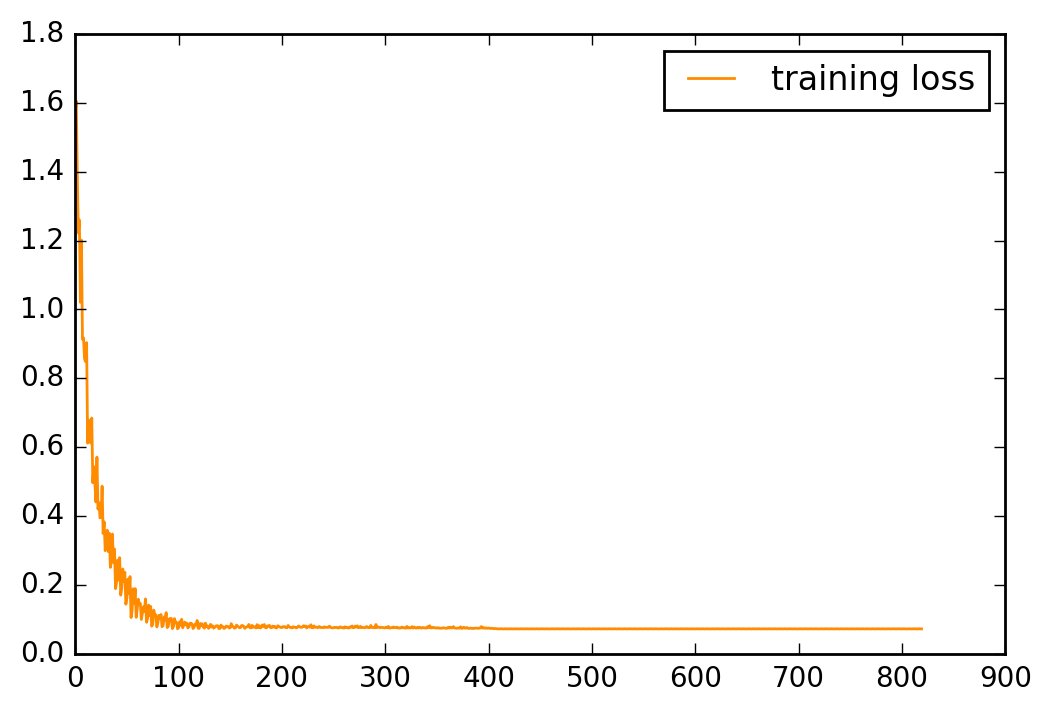

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss, label='training loss', color='darkorange')
plt.legend()
_ = plt.ylim()

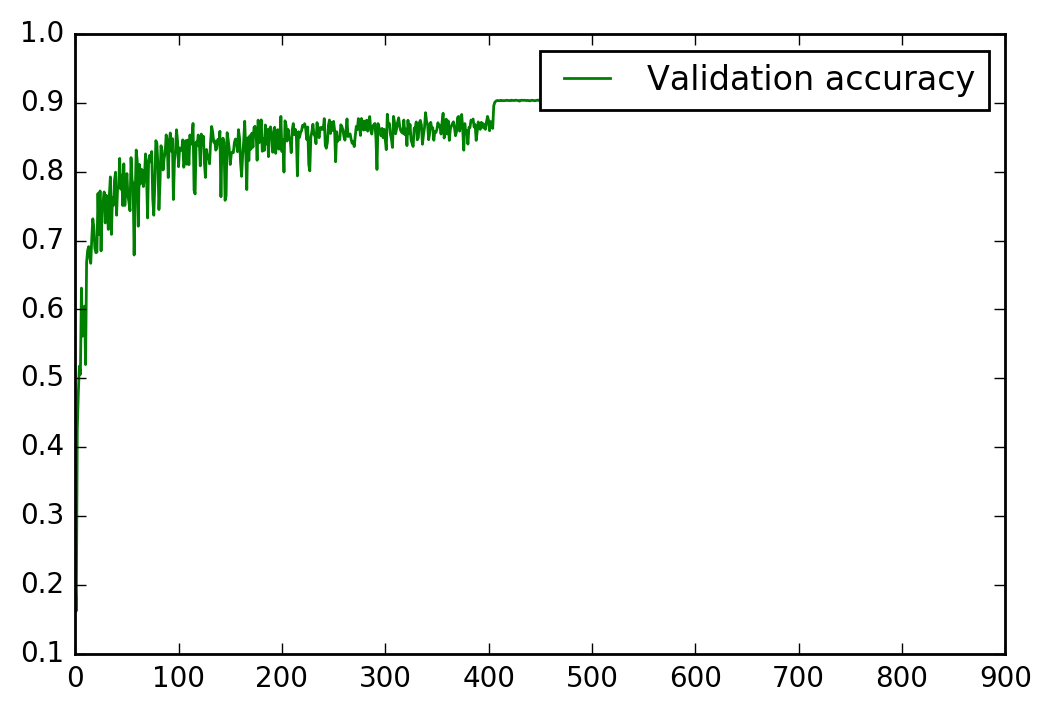

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(acc, label='Validation accuracy', color='green')
plt.legend()
_ = plt.ylim()

In [27]:
for batch_size in [512, 256, 128, 64]:
    for learning_rate_init in [0.1, 0.01, 0.001, 0.0001]:
        
        print('Training for learning_rate={:.5f}, batch_size={} ...'.format(learning_rate_init, batch_size))
        x, y, keep_prob_1, keep_prob_2, lr, summary, optimizer, cost, accuracy, is_training = build_op()

        with tf.Session() as sess:
            steps = 0
            counter = 0
            learning_rate = learning_rate_init
            # Initializing the variables
            sess.run(tf.global_variables_initializer())

            # If you want to compare training and validation, one good way to do it is to use two separate
            # file writer to keep logs for each process but keep them in the same folder. This way, you can 
            # later view them in the same plot. 
            #train_log_string = 'log/train, learning_rate={:.5f}, batch_size={}'.format(learning_rate, batch_size)
            valid_log_string = './tmp/log/valid, learning_rate={:.5f}, batch_size={}'.format(learning_rate_init, batch_size)
            #train_filewriter = tf.summary.FileWriter(train_log_string, sess.graph)
            valid_filewriter = tf.summary.FileWriter(valid_log_string, sess.graph)

            # Training cycle
            for epoch in range(epochs):
                # Loop over all batches
                n_batches = 5
                if epoch >= 81:
                    learning_rate = learning_rate/10
                if epoch >= 122:
                    learning_rate = learning_rate/10
                for batch_i in range(1, n_batches + 1):
                    for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                        steps += batch_features.shape[0]
                        counter += batch_features.shape[0]
                        sess.run(optimizer, feed_dict={x: batch_features, y: batch_labels,
                                                       keep_prob_1:keep_probability[0], keep_prob_2:keep_probability[1],
                                                       lr:learning_rate, is_training:True})

                        # Log only after the model is trained on every 1000 samples. Getting summary takes time, so the 
                        # more frequently you look, the more extra time it'll cost you.
                        if counter > 1000:
                            #train_summ = sess.run(summary, feed_dict={x: batch_features, y: batch_labels,
                            #                                                   keep_prob: 1., lr:learning_rate})
                            #train_filewriter.add_summary(train_summ, steps)
                            valid_summ = sess.run(summary, feed_dict={x: valid_features, y: valid_labels,
                                                                       keep_prob_1:1.0, keep_prob_2:1.0,
                                                                      lr:learning_rate, is_training:False})

                            valid_filewriter.add_summary(valid_summ, steps)
                            counter -= 1000

                    loss = sess.run(cost, feed_dict={x:batch_features, y:batch_labels, keep_prob_1:1.0, keep_prob_2:1.0,
                                                     lr:learning_rate, is_training:True})

                    valid_acc = sess.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob_1:1.0, keep_prob_2:1.0,
                                                              lr:learning_rate, is_training:False})

                    print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
                    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))
            # Save Model
            save_model_path = './model/image_classification(learning_rate={:.5f},batch_size={})'.format(learning_rate_init, batch_size)
            saver = tf.train.Saver()
            save_path = saver.save(sess, save_model_path)

Training for learning_rate=0.10000, batch_size=512 ...
Epoch  1, CIFAR-10 Batch 1:  Loss:     3.5629 Validation Accuracy: 0.097800
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.2266 Validation Accuracy: 0.106400
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.9405 Validation Accuracy: 0.107200
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.8566 Validation Accuracy: 0.136800
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.7959 Validation Accuracy: 0.118600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.8690 Validation Accuracy: 0.187800
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.7293 Validation Accuracy: 0.117000
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.7036 Validation Accuracy: 0.262200
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.5796 Validation Accuracy: 0.213800
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.6553 Validation Accuracy: 0.195600
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.6624 Validation Accuracy: 0.184400
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.6190 Validation Accuracy: 0.207000
Epoch  3, CIFAR-10 Batch 3:  Loss

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

INFO:tensorflow:Restoring parameters from ./image_classification(learning_rate=0.00100,batch_size=128)
Testing Accuracy: 0.8942840189873418



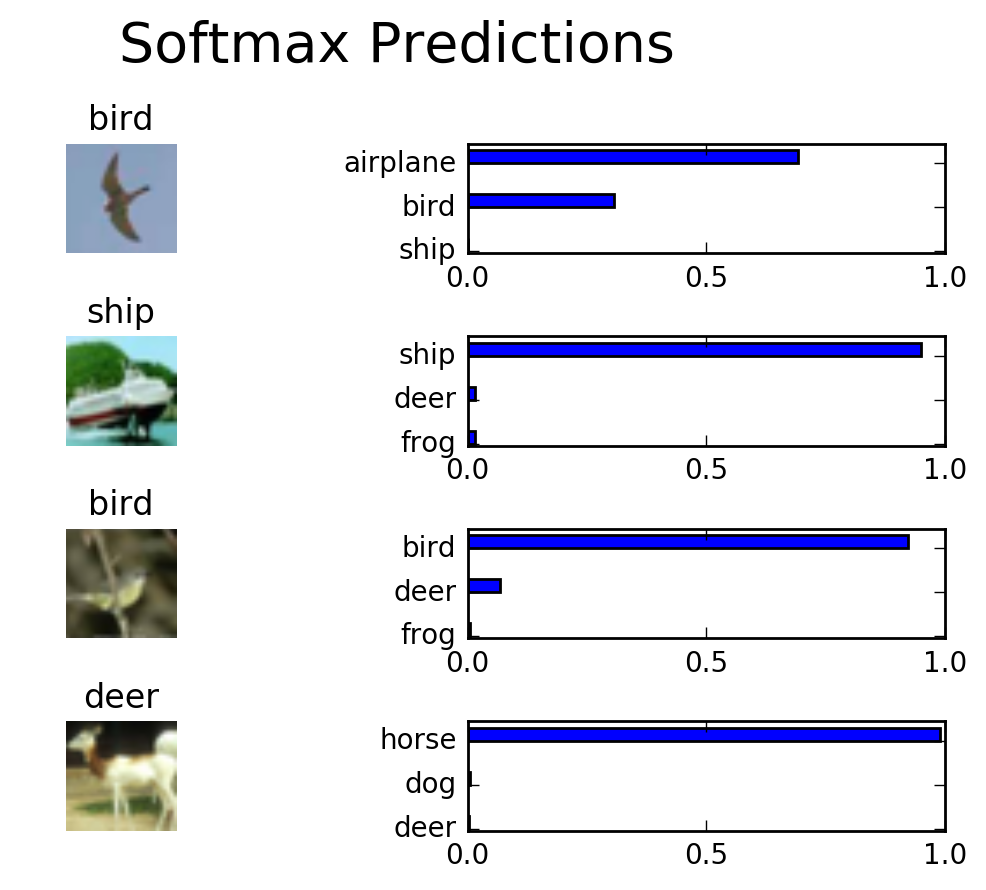

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

# Set batch size if not already set

learning_rate_init = 0.001
batch_size = 128

try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification(learning_rate={:.5f},batch_size={})'.format(learning_rate_init, batch_size)
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('inputs/x:0')
        loaded_y = loaded_graph.get_tensor_by_name('inputs/y:0')
        loaded_keep_prob_1 = loaded_graph.get_tensor_by_name('inputs/keep_prob_1:0')
        loaded_keep_prob_2 = loaded_graph.get_tensor_by_name('inputs/keep_prob_2:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits/logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('predictions/accuracy:0')
        loaded_is_training = loaded_graph.get_tensor_by_name('inputs/is_training:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob_1: 1.0, loaded_keep_prob_2: 1.0,
                           loaded_is_training:False})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob_1: 1.0, loaded_keep_prob_2: 1.0,
                       loaded_is_training:False})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

# The following method about running TensorBoards in Google Colab refer to *[this stackoverflow answer](https://stackoverflow.com/a/48468512).*

Get TensorBoard running in the background. 
*(Inspired by [this answer](https://stackoverflow.com/a/33838211/5222402).)*

In [ ]:
LOG_DIR = '' # set this to your directory of tenosorboard log files, eg.'./tmp/log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [ ]:
! curl http://localhost:6006

Download and unzip [ngrok](https://ngrok.com).

In [ ]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1
! unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1

Launch ngrok background process...

In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')

...and retrieve public url. (Source)

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

If you run against ngrok rate limits, try to use [localtunnel](https://github.com/localtunnel/localtunnel) instead:

In [ ]:
# Install
! npm install -g localtunnel

In [ ]:
# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')

In [ ]:
# Get url
! cat url.txt

## Why 50-80% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.

Some ideas

- Initialize weights to very small
- Initialize biases to zeros

# Bonus: let accuracy over 90%

## 優化 CNN 的方法
- 改善 Gradient Vanishing 問題：
- Xavier Initialization → He Initialization
- Batch Normalization
- Selu (Self-Normalizing ReLU, SNN)
- 讓 Dropout 比例不一：Differential Dropout
- 隨機打亂資料：Random Shuffling
- 考慮模型複雜度的懲罰值：L2 Regularization
- Learning rate decay
- NIN
- **Data Augmentation (source code is in another ipython file: final_dlnd_image_classification_with_DA)**

## 使用 Xavier Initialization + Selu 讓 Accuracy 提升至 79%

上週的結果，使用 Selu 的效果最優，但是當層數增加，我發現 BN 其實還是比較好。

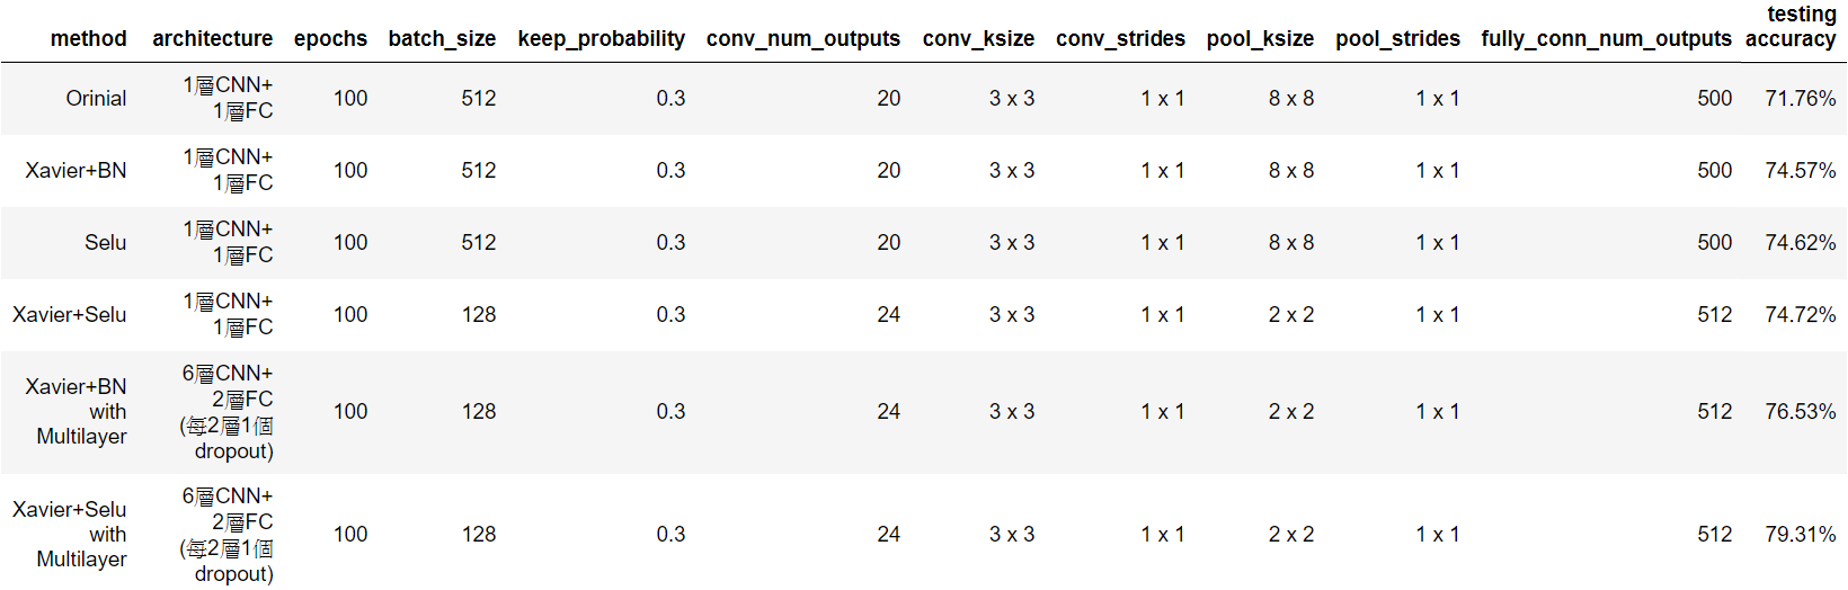

## Final CNN Architecture

本實驗最終的 CNN 架構，共有 9 層 convolution layers 。

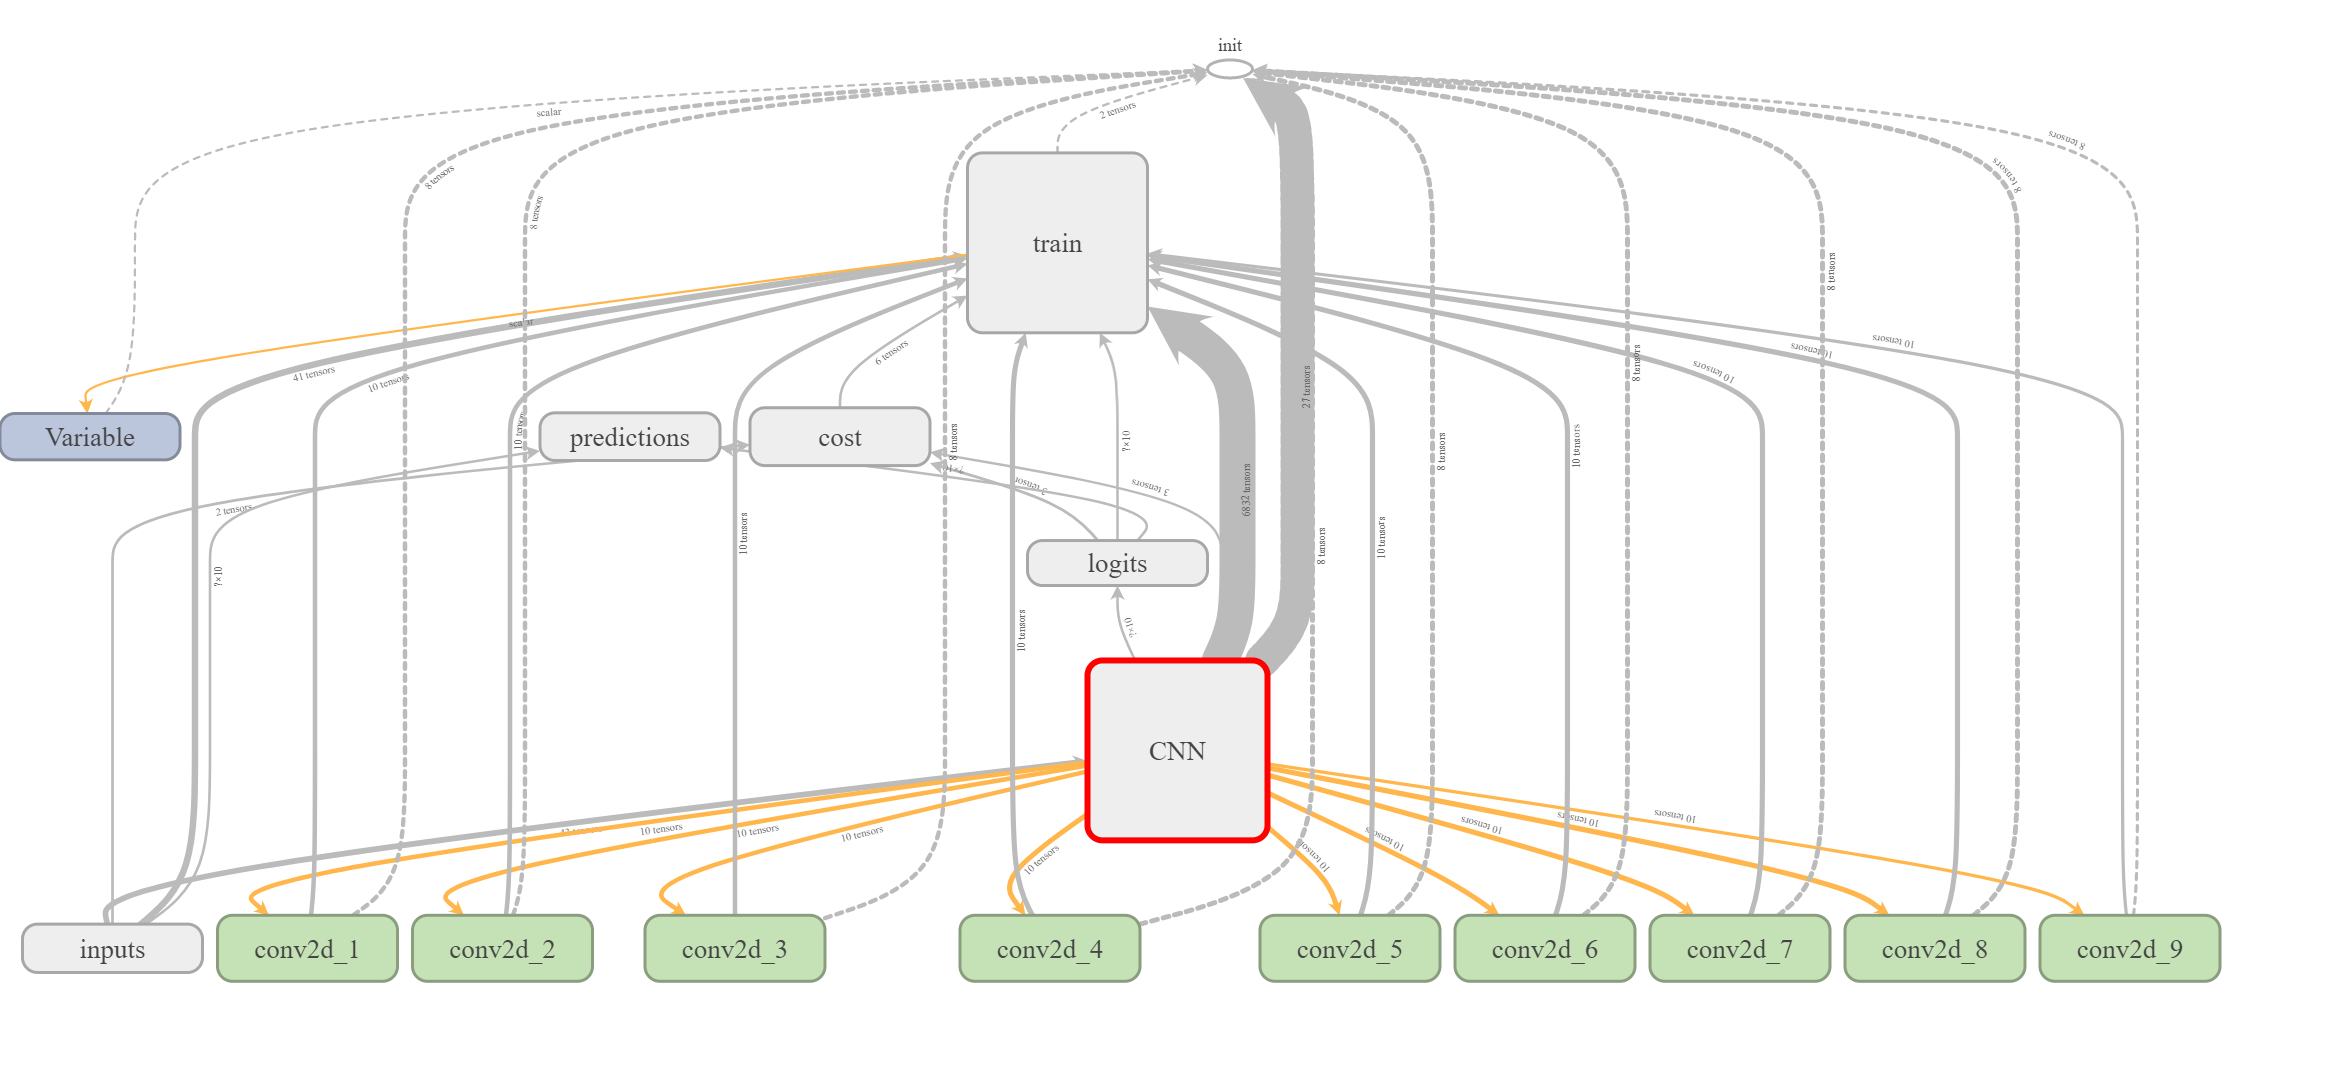

## CNN Layers - NIN (Network in Network)

這裡顯示模型的內部層級細節，其中，我採用 NIN (Network in Network) 這種改進 CNN 的新架構。

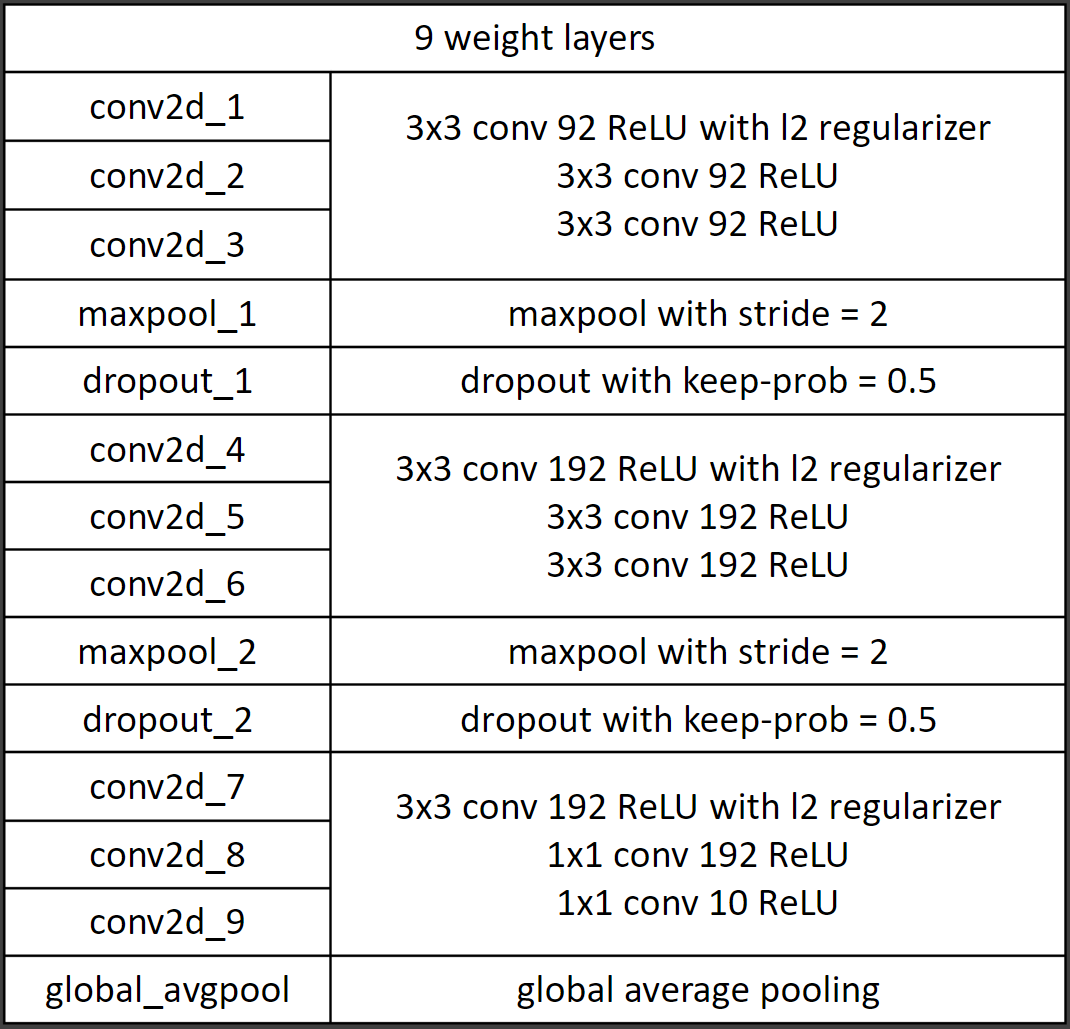

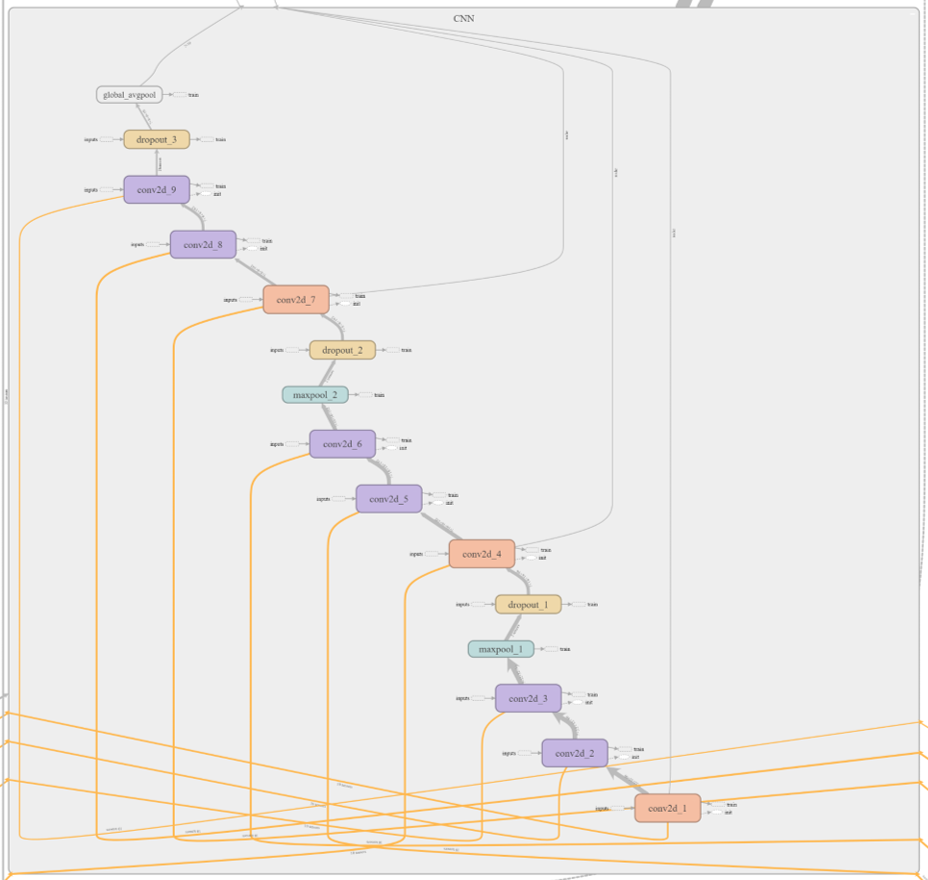

## NIN (Network in Network) 主要有兩大改進

### 1. Mlpconv (multilayer perceptron convolution)

- 在 conv layers 中間加上多層的 fully connected layers。
- 實作上使用 1x1 conv  (又稱 cascaded cross-channel pooling, CCCP)。
- 提高 conv layer 的非線性感知能力。

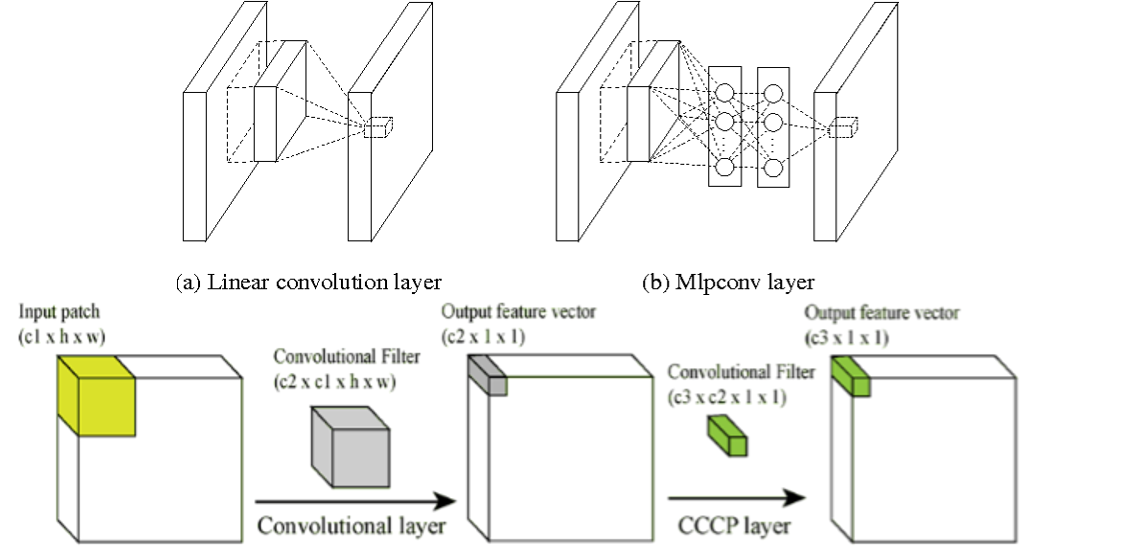

### 2. Global Average Pooling

- 對整個 feature map 取平均值，直接作為output layer的結果。
- 取代 fully connected layers ，大幅減少 parameters 。

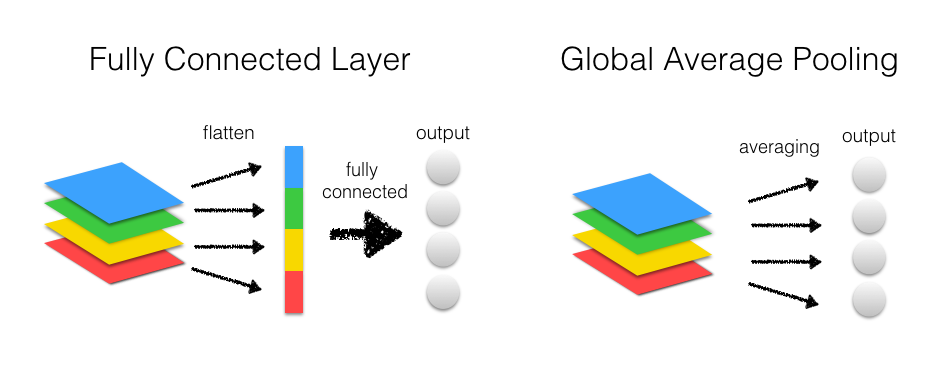

## 使用 Tensorboard 視覺化的結果調整 Hyperparameters

### 1. Choosing Learning Rate

**I make the learning rate decays over 81 epochs and 122 epochs down to 1/10 of the initial learning rate.
So, at about 81th epoch, there is an abrupt increasing!**

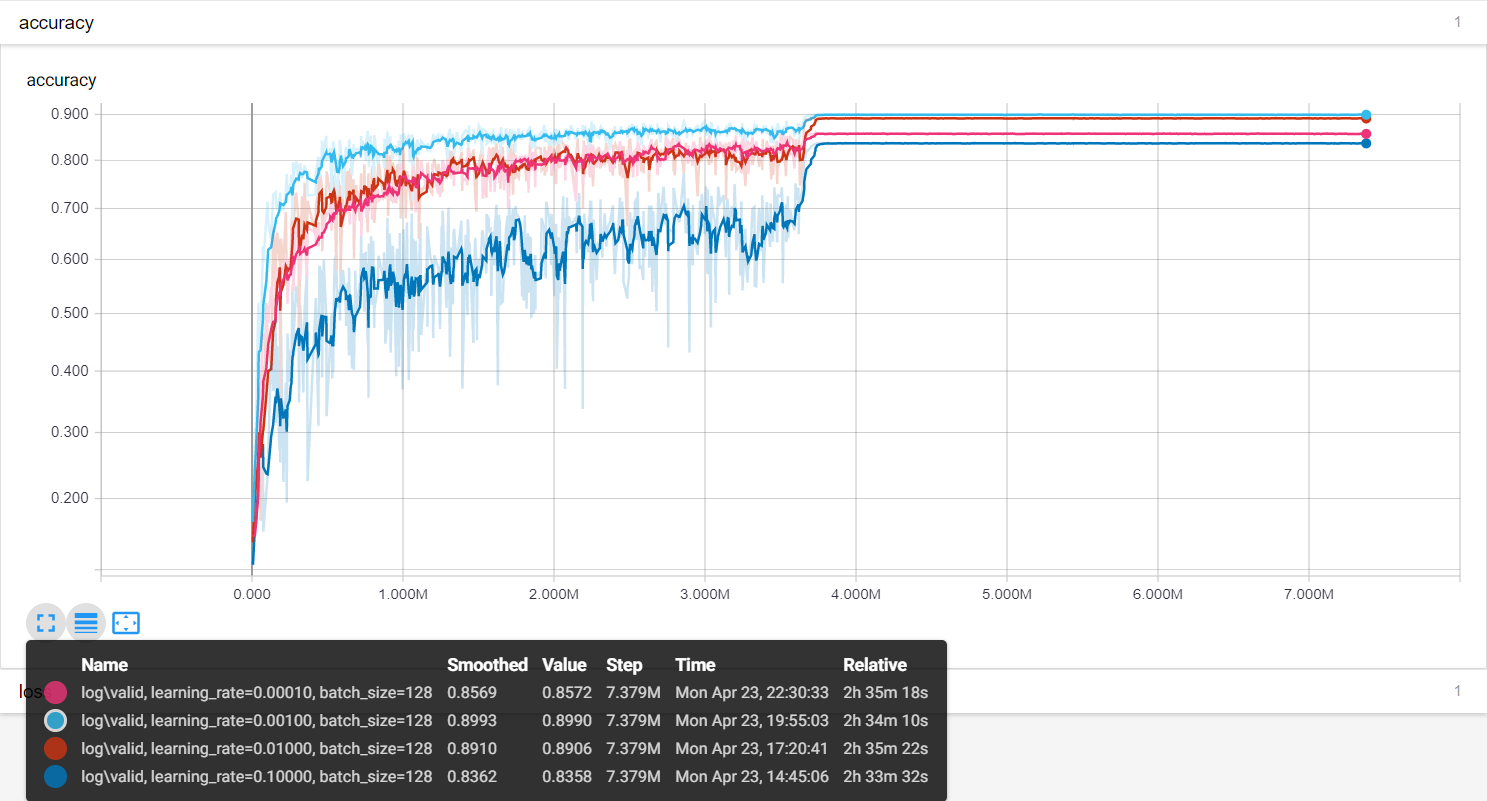

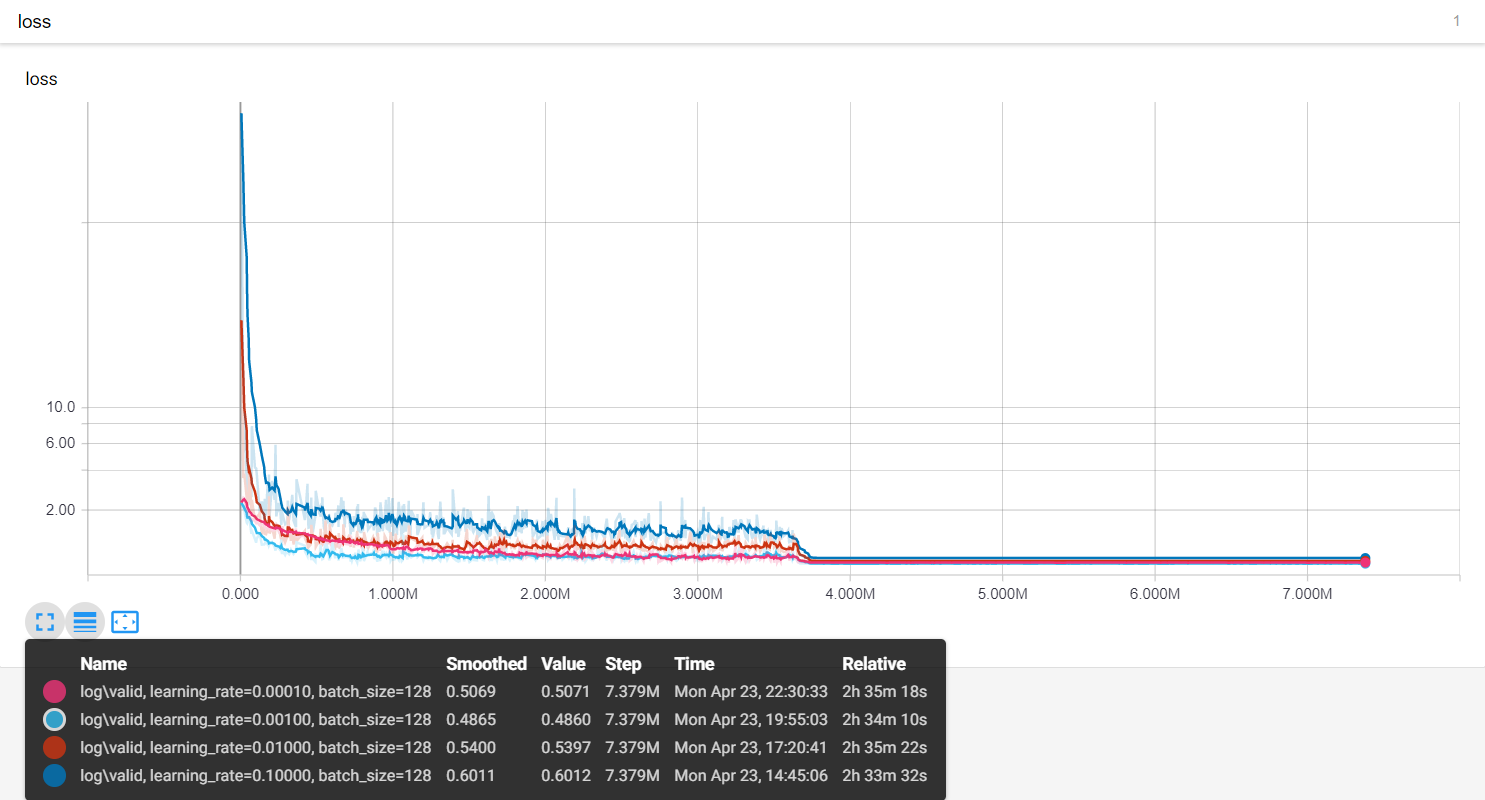

結果顯示當 learning rate 為 0.001 時，收斂最快，準確率也最高。而 learning rate decay 可以在模型學完粗略的部分之後，以更小的 learning rate 學習更到細膩的部份，可由圖中約 81 epoch 時的突然變化得知的確有效。

### 2. Choosing Batch Size

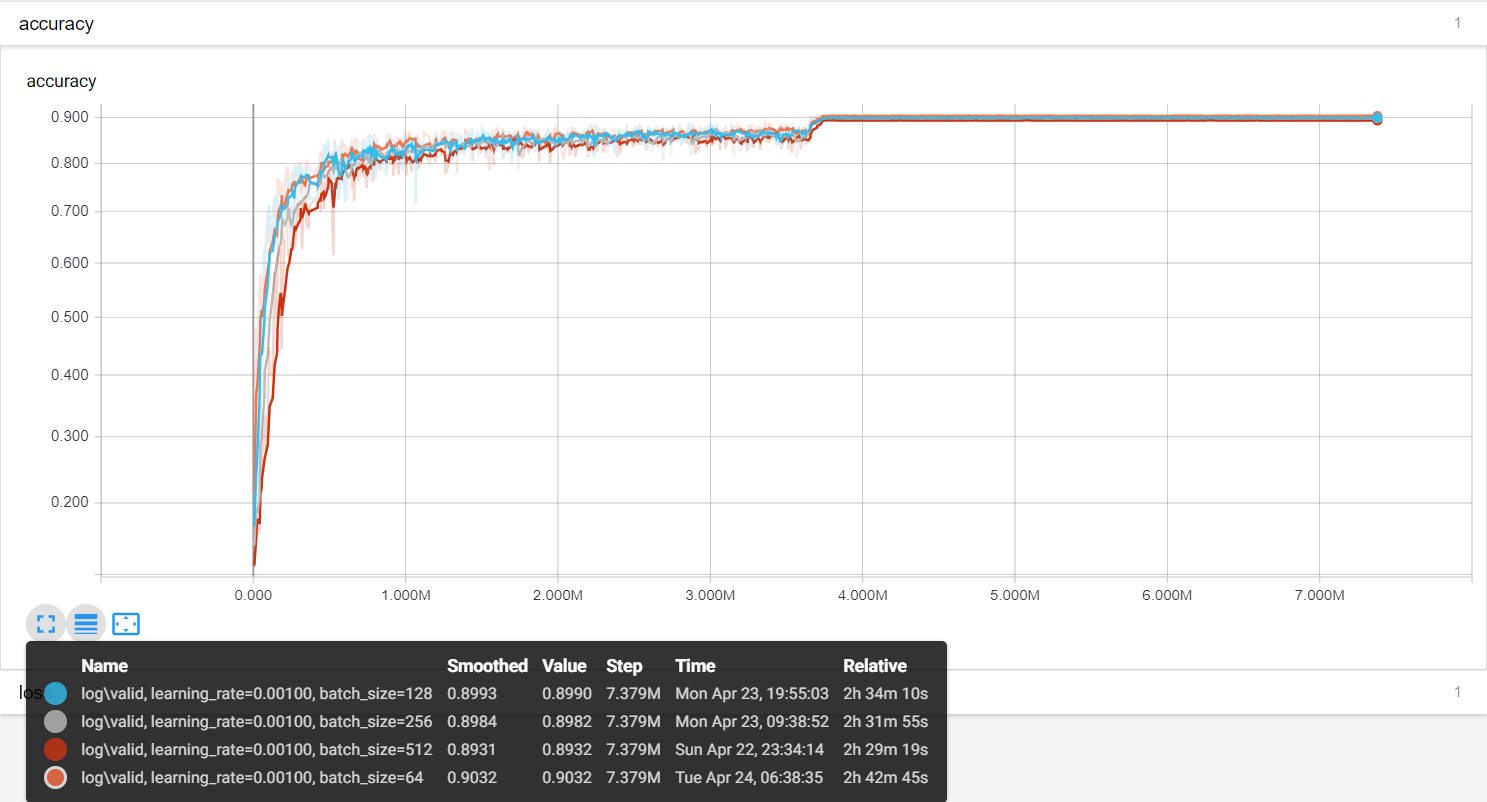

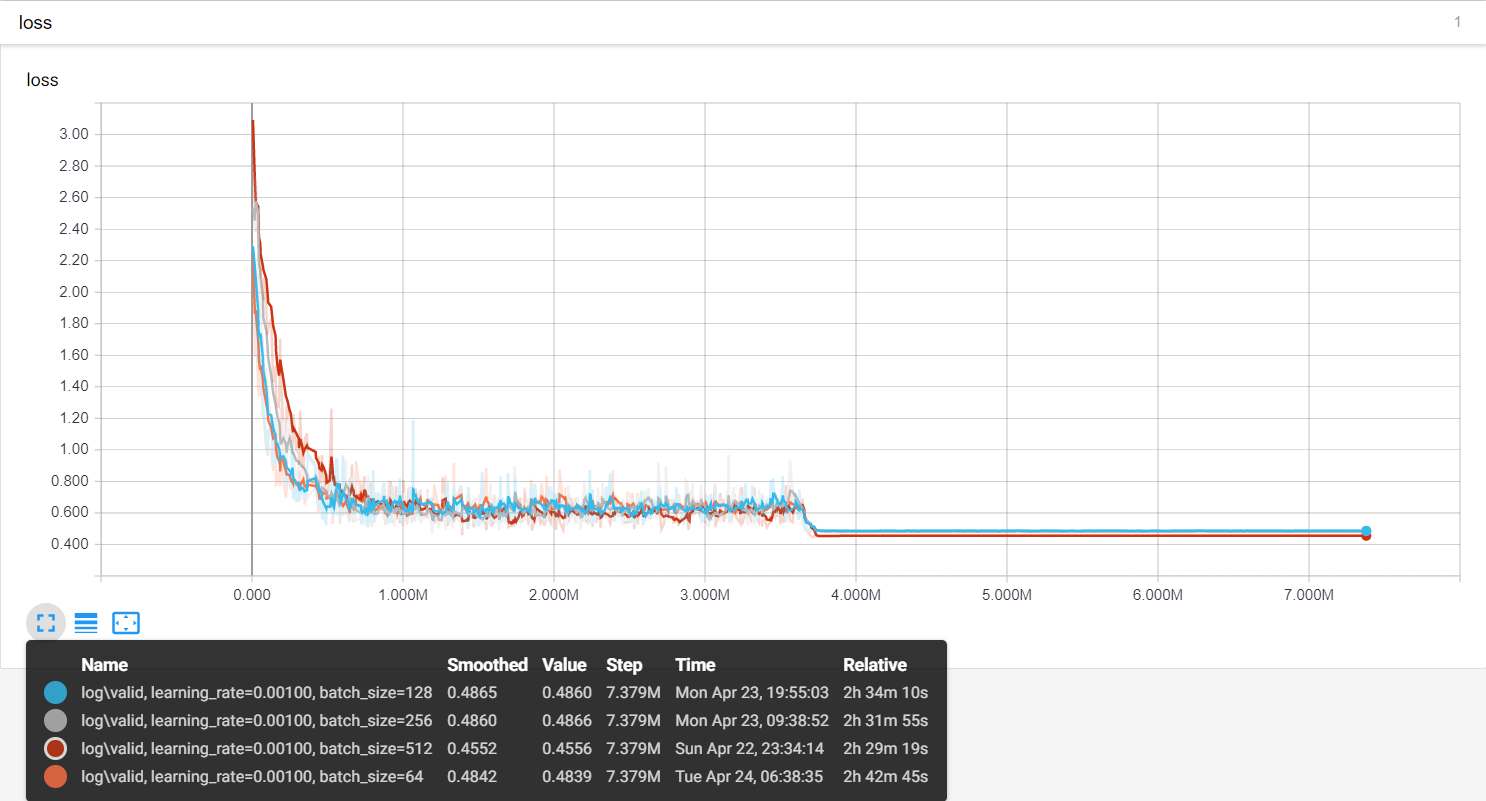

結果顯示當 batch size 對於模型的準確度影響不大。大的 batch size 因為一次看的資料多，學習穩定，不易產生訓練震盪，且訓練較快，但是比較占記憶體；小的 batch size 每次只看一小批資料，在訓練過程中較不穩定，且較不吃記憶體，卻需較久的時間。

## 權重分布

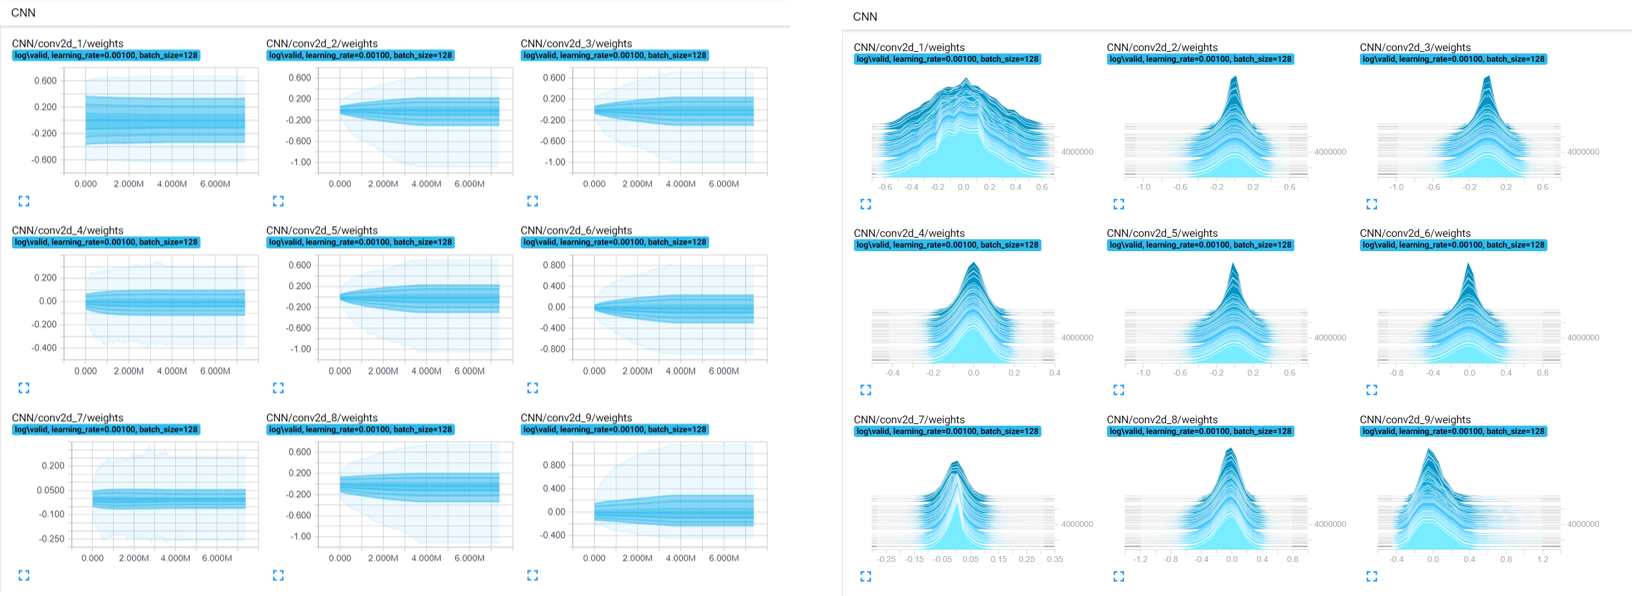


## Data Augmentation

我使用 [imgaug](https://github.com/aleju/imgaug) 這個 python package 做 data augmentation 。

我先將 5 份 batch data (10000 images/batch data) 做 random shuffling 並切出 90% 作為 train batch data (9000 images/train batch data) ，並將 5 份剩下的 10% 集合成 validation data (5000 images/validation data) ，再將 5 份 train batch data 做 data augmentation ，每張 image 擴增 9 份，總共多產生 5 份 augmentation train batch data (81000 images/aug train batch)。

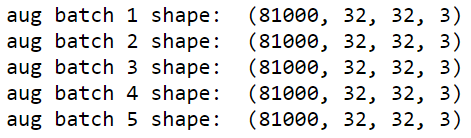

最後將 train batch data 與 augmentation train batch data 合併成 100000 images/batch ，然後隨機切成 10 等份做為新的 train batch data ，餵入模型訓練。

而其中我所使用到的 data augmentation 方法如下表：

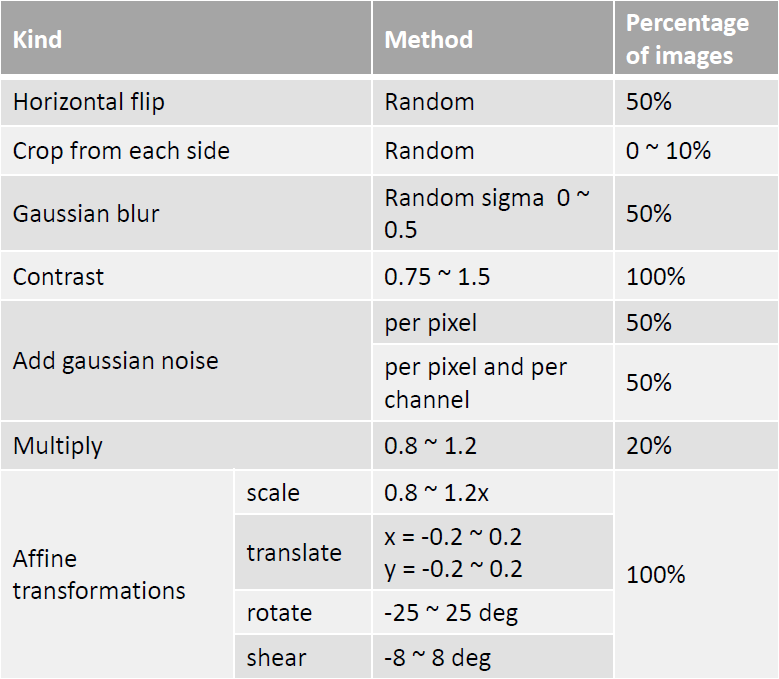

產生出的圖片如下所示：

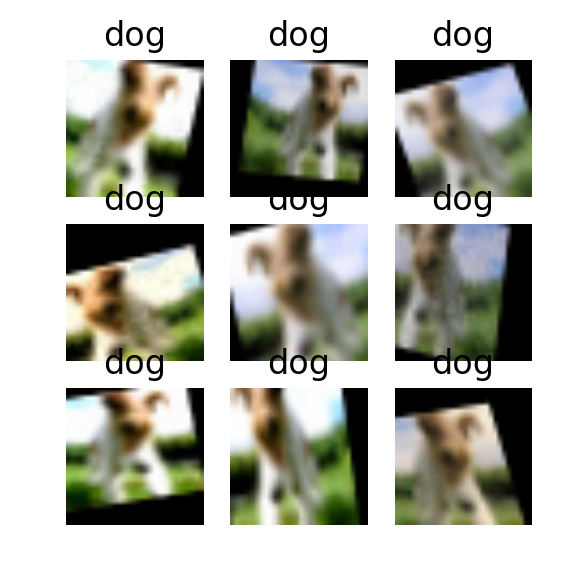


## Result

### 1. Validation Accuracy

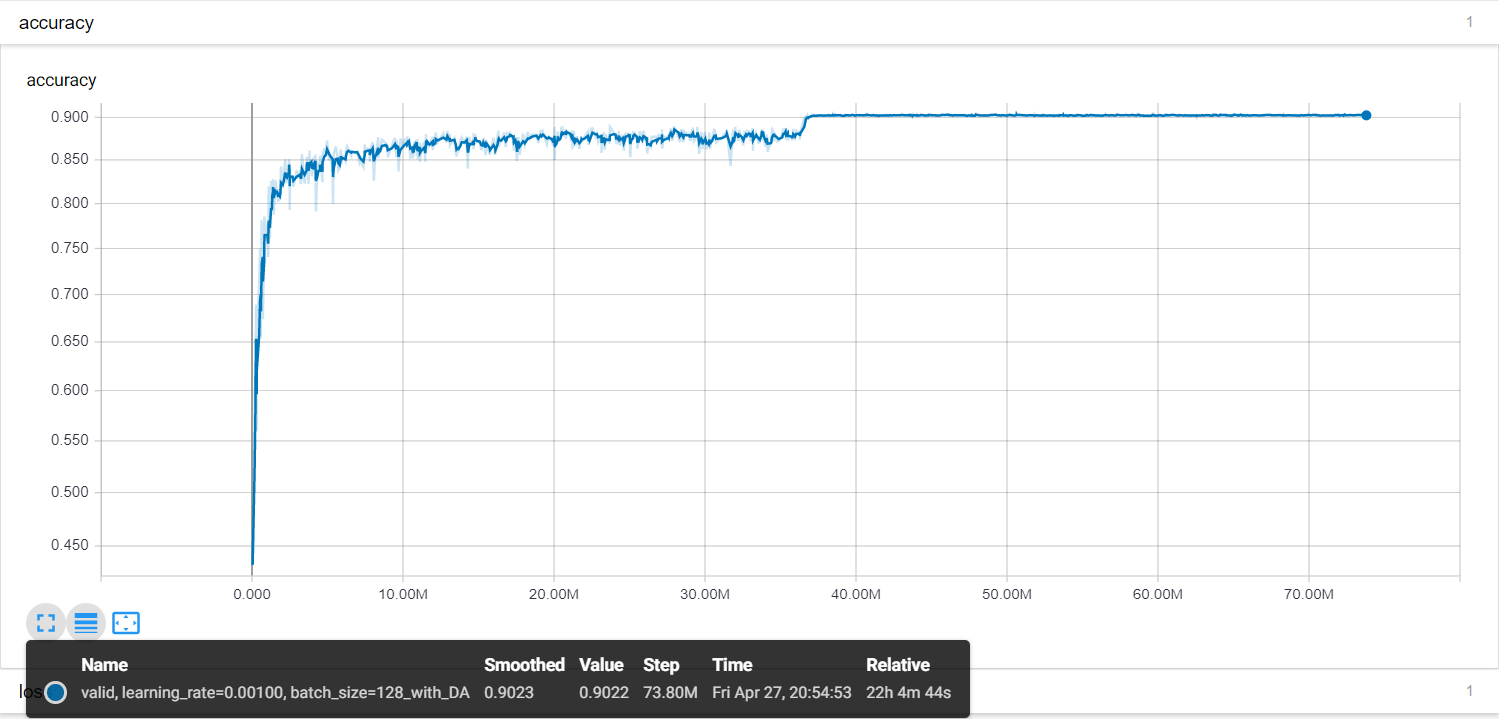

### 2. Training Loss

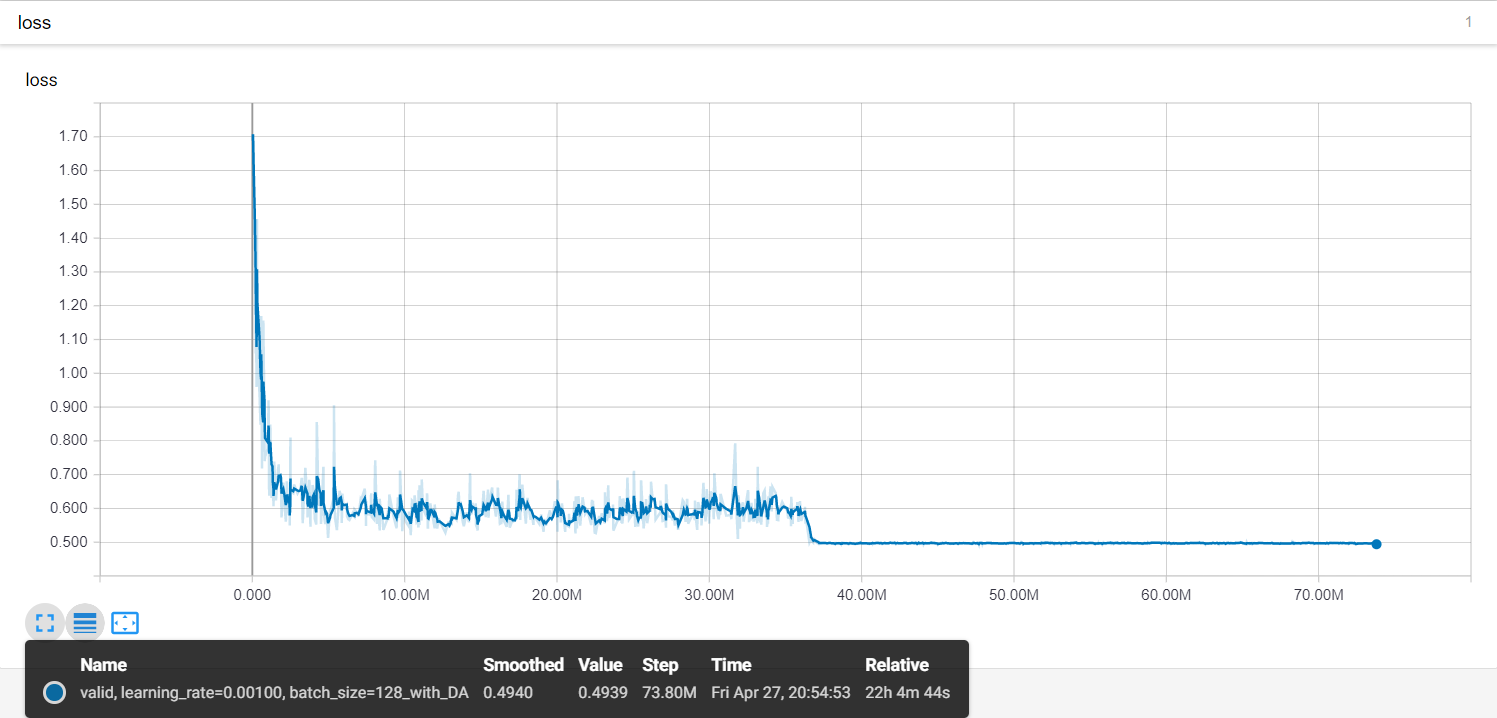

### 3. Weights Distributions and Histograms

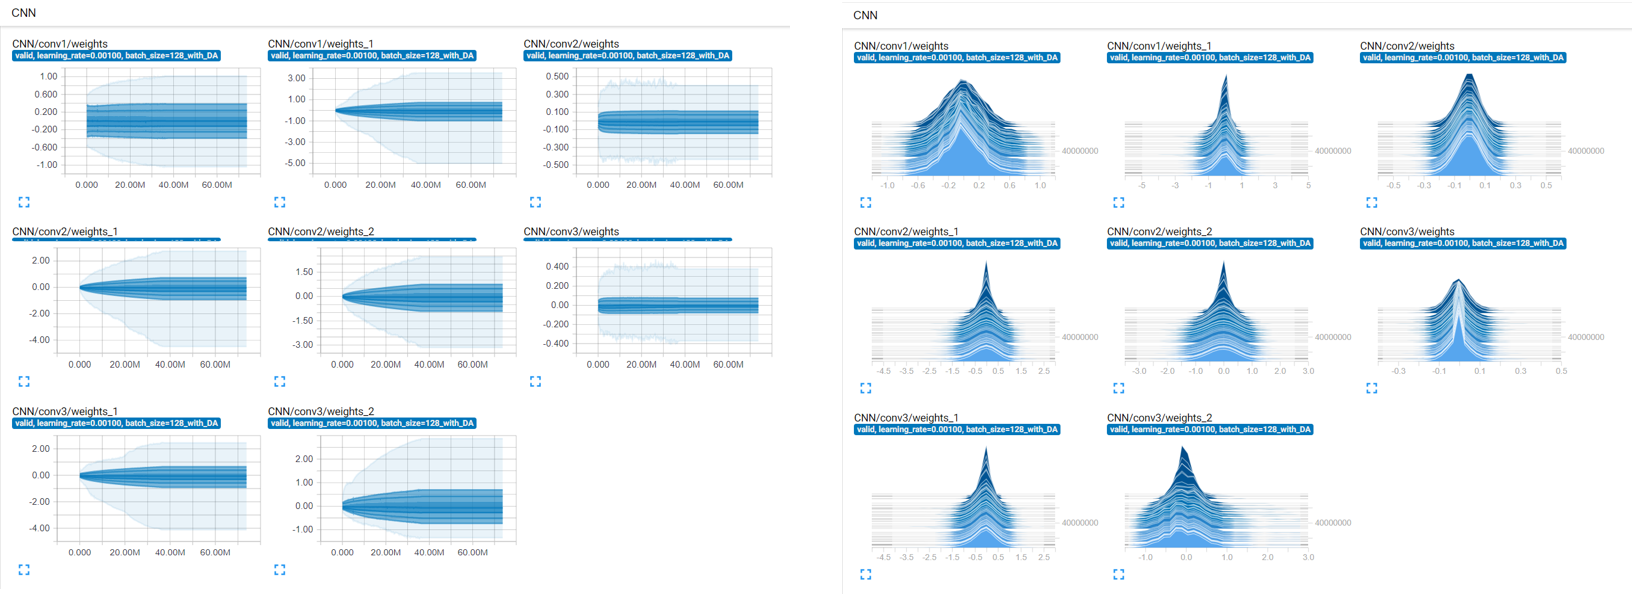

## Final Model and Testing Accuracy

最後我選擇：
 - Batch size : 128
 - Initial learning rate : 0.001
 - Epochs : 164
 


***

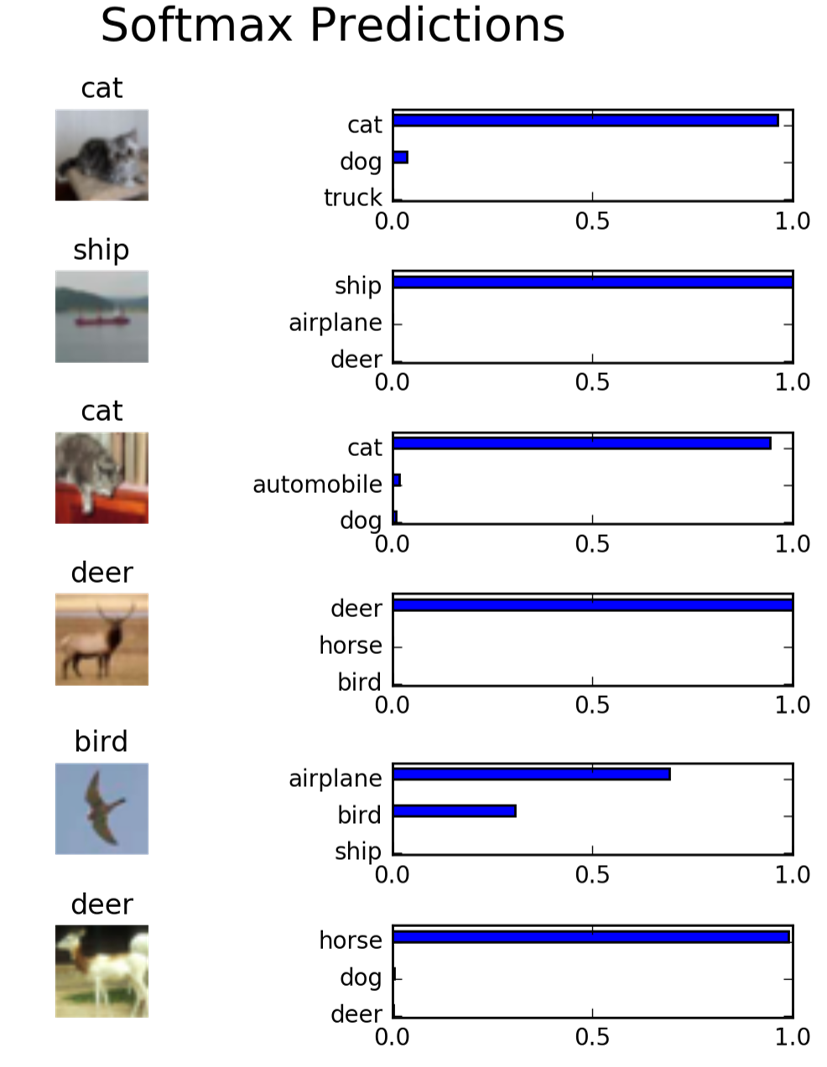

## Reference

- 《Network In Network》: https://arxiv.org/pdf/1312.4400.pdf

- 《Striving For Simplicity：The All Convolutional Net》: https://arxiv.org/pdf/1412.6806.pdf

- NIN: https://github.com/BIGBALLON/Deep-learning-and-practices/tree/master/Lab3-NIN

- Xavier Initialization: http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

- 《Self-Normalizing Neural Networks》: https://arxiv.org/pdf/1706.02515.pdf![image.png](attachment:image.png)